In [232]:
import qml
import pyscf
import numpy as np
import pandas as pd
from pyscf import gto, dft
from scipy.special import comb
import pandas as pd
import pyscf.qmmm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
basepath = '/mnt/c/Users/guido/data/qm9/'

In [96]:
fns = pd.read_csv(basepath + 'index', names=['fn']).fn.values

In [84]:
def get_electronic_energy(nuclear_charges, coordinates):
    mol = gto.Mole(verbose=0)
    mol.build(atom=list(zip(nuclear_charges, coordinates)), basis='631G')
    calc = pyscf.scf.RHF(mol)
    total = calc.scf()
    
    return total-mol.energy_nuc()
def get_electronic_potential(nuclear_charges, coordinates, atoms):
    mol = gto.Mole(verbose=0)
    mol.build(atom=list(zip(nuclear_charges, coordinates)), basis='631G')
    calc = pyscf.scf.RHF(mol)
    total = calc.scf()
    
    dm1 = calc.make_rdm1()
    dm1_ao = np.einsum('pi,ij,qj->pq', calc.mo_coeff, dm1, calc.mo_coeff.conj())
    
    epns = []
    for site in atoms:
        mol.set_rinv_orig_(mol.atom_coords()[site])
        epns.append(np.matmul(dm1_ao, mol.intor('int1e_rinv')).trace())
        
    return epns

In [18]:
def get_site_similarity(c):
    atoms = np.where(c.nuclear_charges == 6)[0]
    a = qml.representations.generate_coulomb_matrix(c.nuclear_charges, c.coordinates, size=c.natoms, sorting='unsorted')
    s = np.zeros((c.natoms, c.natoms))
    s[np.tril_indices(c.natoms)] = a
    d = np.diag(s)
    s += s.T
    s[np.diag_indices(c.natoms)] = d
    sorted_elements = [np.sort(_) for _ in s[atoms]]
    ret = []
    for i in range(len(atoms)):
            for j in range(i+1, len(atoms)):
                dist = np.linalg.norm(sorted_elements[i] - sorted_elements[j])
                ret.append([atoms[i], atoms[j], dist])
    return ret

In [43]:
def scan_mol(fn):
    c = qml.Compound(fn)
    ret = []
    for i, j, dist in get_site_similarity(c):
        try:
            q = c.nuclear_charges.copy()
            q[i] = 5
            q[j] = 7
            up = get_electronic_energy(q, c.coordinates)
            q = c.nuclear_charges.copy()
            q[i] = 7
            q[j] = 5
            dn = get_electronic_energy(q, c.coordinates)
            gap = up-dn
            ret.append({'site1': i, 'site2': j, 'dist': dist, 'gap': gap})
            print (fn.split('_')[-1], i, j, dist, gap)
        except:
            continue
    return pd.DataFrame(ret)
#df = scan_mol(basepath + fns[0])

In [6]:
df = pd.read_csv('summary', names='fn site1 site2 dist gap molsim epn1 epn2'.split(), sep=' ')

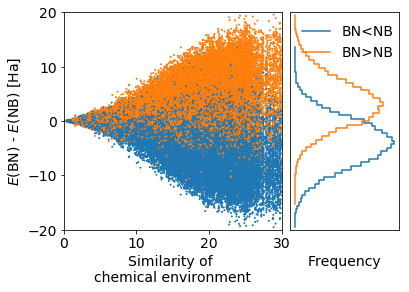

In [431]:
# Inequal molecules BN and NB!
plt.rc('font', size=14)
gs = gridspec.GridSpec(1, 2,width_ratios=[2, 1])
gs.update(wspace=0.05)
fig = plt.figure()
ax_scatter = plt.subplot(gs[0])
ax_hist = plt.subplot(gs[1])

s = df2[df2.molsim > 5]
ax_scatter.scatter(s.dist, s.gap, s=1,color=['C%d' % _ for _ in (s.epn1 + s.epn2 >s.epn3 + s.epn4).astype(int)])
s = df[df.molsim > 5]
ax_scatter.scatter(s.dist, s.gap, s=1, color=['C%d' % _ for _ in (s.epn1 > s.epn2).astype(int)])


ax_scatter.set_xlabel('Similarity of \nchemical environment')
ax_scatter.set_ylabel('$E$(BN) - $E$(NB) [Ha]')
ax_scatter.set_ylim(-20, 20)
ax_scatter.set_xlim(0, 30)

bincount = 50
s = df[df.molsim > 5]
Lgaps = [s[s.epn1<s.epn2].gap.values]
Rgaps = [s[s.epn1>s.epn2].gap.values]
s = df2[df2.molsim > 5]
Lgaps.append(s[s.epn1 + s.epn2 <s.epn3 + s.epn4].gap.values)
Rgaps.append(s[s.epn1 + s.epn2 >s.epn3 + s.epn4].gap.values)


hist, bins = np.histogram(np.hstack(Lgaps), bins=bincount)
ys = np.vstack((bins, bins)).T.flatten()[1:-1]
xs = np.vstack((hist, hist)).T.flatten()
ax_hist.plot(xs, ys, label='BN<NB')
hist, bins = np.histogram(np.hstack(Rgaps), bins=bincount)
ys = np.vstack((bins, bins)).T.flatten()[1:-1]
xs = np.vstack((hist, hist)).T.flatten()
ax_hist.plot(xs, ys, label='BN>NB')
ax_hist.set_xticks([])
ax_hist.set_yticks([])
ax_hist.set_xlabel('Frequency')
ax_hist.legend(frameon=False)

ax_hist.set_ylim(-20, 20)

fig.align_xlabels([ax_hist, ax_scatter])

In [385]:
df2 = pd.read_csv('summary-2pairs', names='fn site1 site2 site3 site4 dist gap molsim epn1 epn2 epn3 epn4'.split(), sep=' ')

In [91]:
# alchemical estimate of max error

In [223]:
import pyscf
import functools

In [284]:
c = qml.Compound(basepath + './coord/00/c7/dsgdb9nsd_092870.xyz')

In [380]:
@functools.lru_cache(100)
def get_interpolator(Z, deltaZ):
    if Z == 1:
        spin = 1
    if Z == 6:
        spin = 2
    if Z == 7:
        spin = 3
    if Z == 8:
        spin = 2
    if Z == 5:
        spin = 1
    mol = gto.M(atom='%d 0 0 0' % Z, verbose=0, basis='631G', spin=spin)
    
    calc = pyscf.scf.UHF(mol)
    mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords(), [deltaZ])
    class NoSelfQMMM(mf.__class__):
            def energy_nuc(self):
                    return self.mol.energy_nuc()
    mf = NoSelfQMMM()
    total = mf.scf()
    dm1 = mf.make_rdm1()
    dm1_aoa = np.einsum('pi,ij,qj->pq', mf.mo_coeff[0], dm1[0], mf.mo_coeff[0].conj())
    dm1_aob = np.einsum('pi,ij,qj->pq', mf.mo_coeff[1], dm1[1], mf.mo_coeff[1].conj())
    xs = np.hstack((np.linspace(0, 1, 10), np.linspace(2, 10, 10), np.linspace(11, 30, 10)))
    ys = []
    for x in xs:
        mol.set_rinv_orig_([0., 0., x])
        ys.append(np.matmul(dm1_aoa, mol.intor('int1e_rinv')).trace()+np.matmul(dm1_aob, mol.intor('int1e_rinv')).trace())
    return interp1d(xs, ys, kind='cubic')

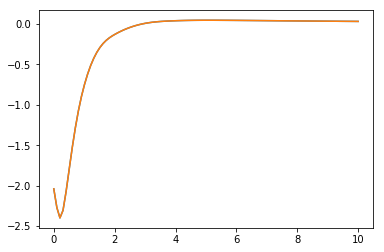

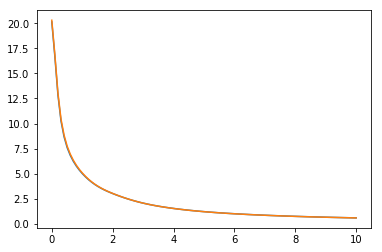

In [381]:
xs = np.linspace(0, 10, 100)
delta = 0.04
plt.plot(xs, (get_interpolator(8, delta)(xs) - get_interpolator(8, -delta)(xs))/(2*delta))
delta = 0.04
plt.plot(xs, (get_interpolator(8, delta)(xs) - get_interpolator(8, -delta)(xs))/(2*delta))
plt.show()
plt.plot(xs, (get_interpolator(8, delta)(xs)))
plt.plot(xs, (get_interpolator(8, -delta)(xs)))

In [384]:
def get_fd_coefficients(order):
    if order == 0:
        return [0], [1]
    #shifts, weights = [], []
    delta =0.04
    #for i in range(order+1):
    #    shifts.append(((order/2)-i)*delta)
    #    weights.append((-1)**i*comb(order, i) / (1))
    #return shifts, weights
    cs = findiff.coefficients(deriv=order, acc=order)['center']
    return cs['offsets']*delta, cs['coefficients']/(delta**order)
        
def get_alchemy_bound(nuclear_charges, coordinates, delta_atoms, delta_Zs, orders):
    total_bound = []
    factorial = [1, 1, 2, 6, 24, 24*5]
    for order in orders:
        bound = 0.
        for shift, weight in zip(*get_fd_coefficients(order)):
            q = nuclear_charges.copy()
            q[delta_atoms] += delta_Zs
            for I, delta_Z in zip(delta_atoms, delta_Zs):
                for j in range(len(nuclear_charges)):
                    bound += delta_Z*weight*get_interpolator(nuclear_charges[j], shift*(q[j] - nuclear_charges[j]))(1.8892*np.linalg.norm(coordinates[j]-coordinates[I]))
        total_bound.append(bound / factorial[order])
    return total_bound
get_alchemy_bound(c.nuclear_charges, c.coordinates, [0, 1], [1, -1], [0, 1, 2, 3, 4])

[-2.4623638602247837,
 2.3844973994097876,
 -1.0267342531733448e-12,
 1171.3708976494843,
 6.571478176435145e-10]

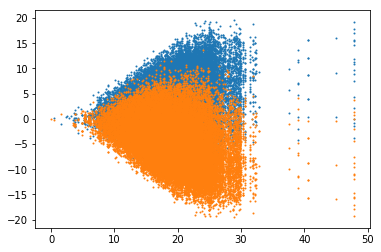

In [396]:
s = df2[df2.molsim > 5]
q = s[s.epn1 + s.epn2 >s.epn3 + s.epn4]
plt.scatter(q.dist, q.gap, s=1)
q = s[s.epn1 + s.epn2 <s.epn3 + s.epn4]
plt.scatter(q.dist, q.gap, s=1)

In [393]:
df2

,fn,site1,site2,site3,site4,dist,gap,molsim,epn1,epn2,epn3,epn4
0,087663.xyz,0,1,2,3,22.606829,-7.698873,64.059912,11.128537,14.099387,12.223352,14.901763
1,087663.xyz,0,1,2,5,26.599745,-5.477943,60.067701,11.128537,14.099387,12.223352,14.032082
2,087663.xyz,0,1,2,7,15.843961,-2.503925,49.524614,11.128537,14.099387,12.223352,11.306067
3,087663.xyz,0,1,2,8,15.843961,-3.461559,68.064670,11.128537,14.099387,12.223352,12.986953
4,087663.xyz,0,1,3,5,26.599745,-11.467889,63.238488,11.128537,14.099387,14.901763,14.032082
5,087663.xyz,0,1,3,7,22.606829,-8.491586,58.284503,11.128537,14.099387,14.901763,11.306067
6,087663.xyz,0,1,3,8,22.606829,-9.467169,54.749712,11.128537,14.099387,14.901763,12.986953
7,087663.xyz,0,1,5,7,26.599745,-6.321653,62.620834,11.128537,14.099387,14.032082,11.306067
8,087663.xyz,0,1,5,8,26.599745,-7.312350,61.797274,11.128537,14.099387,14.032082,12.986953
9,087663.xyz,0,1,7,8,15.843961,-4.377538,40.497806,11.128537,14.099387,11.306067,12.986953


In [403]:
len(df2), len(df)

(93239, 17855)